In [ ]:
# import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon as JS
import matplotlib.transforms as mtransforms
# from google.colab import files

# Set up functions for running mass balance formulas against HYDRUS

In [ ]:
def prep_data(nodespacing,timeres=1):
  # prepare data for running a mass balance method
  # for a certain temporal and vertical resolution

  alldata['Nodegroup'] = np.where(alldata.Depth>=-1*nodespacing,1,-1)
  nodedepths = list(range(nodespacing,801,nodespacing))
  for i,thresh in enumerate(nodedepths):
    alldata['Nodegroup'] = np.where((-alldata.Depth<=thresh) & (alldata.Nodegroup<0),
                                  i+1,alldata.Nodegroup)

#   pet = ml.read_tlevel()[['rRoot','rTop']]
#   pet['rTop'] = np.where(pet.rTop<0,0,pet.rTop)
#   pet = pet.sum(axis=1).rename('PET').to_frame()


#   et = ml.read_tlevel()[["vRoot"]]
#   et = et.sum(axis=1).rename('vRoot')

  ETdata = alldata[['Nodegroup','time','Sink']].groupby(['Nodegroup',
                                                        'time']).sum().reset_index().set_index('time')
  ETdata = ETdata.merge(et,left_index=True,right_index=True)
  ETdata['ET'] = ETdata.Sink#*ETdata.vRoot
  ETdata.drop(columns=['Sink','vRoot'],inplace=True)

  wcdata = alldata[['Nodegroup','time','Moisture']].groupby(['Nodegroup','time']).mean().reset_index().set_index('time')

  fluxdata = alldata[alldata.Node.isin(list(range(10,801,10)))][['Nodegroup','time','Flux']].groupby(
      ['time','Nodegroup',]).last().reset_index().set_index('time')

#   rain = ml.atmosphere['Prec'].reset_index()
#   rain['time'] = list(range(1,len(rain)+1))
  combodata = wcdata.reset_index().merge(fluxdata.reset_index(),on=['time','Nodegroup'])
  combodata = combodata.merge(ETdata.reset_index().rename(columns={'ET':'ETnode',
                                                                  'index':'time'}),
                              on=['time','Nodegroup'])
  combodata['deltaS'] = (combodata.Moisture*10).diff().fillna(0)
  # print(combodata.head())
  combodata = combodata.merge(rain.drop(columns='Timestamp'),
                              on='time')

  return(combodata,nodedepths)

In [ ]:
def calc_fluxes_mymethod(num_ports,nodespacing,timeres=1):
  # run Method 3 (minimum drainage) on HYDRUS fluxes to get
  # depth-distributed ET and drainage fluxes

  Storages = []
  for node in combodata.Nodegroup.unique():
    if node==1:
      nodefactor = nodespacing
    else:
      nodefactor = nodespacing
    Storages.append((combodata[combodata.Nodegroup==node][['time',
                                                          'Moisture']].set_index(
                                                              'time')*nodefactor).rename(columns={
                                                                  'Moisture':node}))
  Storages = pd.concat(Storages,axis=1)
  Storages = Storages.iloc[::timeres]

  # calculate deltaS for each timestep
  DeltaStorage = Storages.diff().dropna()
  P = rain.rename(columns={'Prec':'J [mm/h]'})[['J [mm/h]']].shift(1)
  DeltaStorage = DeltaStorage.merge(P.rolling(timeres,center=False).sum(),
                                    left_index=True,right_index=True)
  ports = list(range(1,num_ports+1))

  # data checks
  # 1. confirm that the change over no single layer exceeds incoming P

  # remove first step because it fails P test and no prior P to correct with
  DeltaStorage = DeltaStorage#.iloc[2:]

  # make a column of minimum J needed to meet requirement
  collist = []
  for col in ports+[ports[-1]+1]:
      collist.append(col)
      DeltaStorage['minJ_'+str(col)] = DeltaStorage[collist].sum(axis=1)

  DeltaStorage['minJ'] = DeltaStorage[['minJ_'+str(i) for i in ports+[ports[-1]+1]]].max(axis=1)
  DeltaStorage.drop(columns=['minJ_'+str(i) for i in ports+[ports[-1]+1]],inplace=True)

  # find timesteps where requirement is not met.
  DeltaStorage['Jdiff'] = DeltaStorage['J [mm/h]']-DeltaStorage.minJ
  DeltaStorage['Jadjust'] = DeltaStorage['J [mm/h]'].values
  DeltaStorage['Jdiff_new'] = DeltaStorage.Jdiff.values


  Jdiffnew = list(DeltaStorage.Jdiff)
  for i in range(len(DeltaStorage)):
      if DeltaStorage.Jdiff.values[i]<0:
          # if excess P available in previous timestep, shift it
          adjustby = 0
          if DeltaStorage.Jdiff_new.values[i-1]>=abs(DeltaStorage.Jdiff_new.values[i]):
              adjustby = abs(DeltaStorage.Jdiff.values[i])
              Jdiffnew[i] = 0
              Jdiffnew[i-1] -= adjustby
              DeltaStorage['Jdiff_new'] = Jdiffnew
          else:
              adjustby = abs(DeltaStorage.Jdiff_new.values[i-1])
              Jdiffnew[i]+=adjustby
              Jdiffnew[i-1] = 0
              DeltaStorage['Jdiff_new'] = Jdiffnew
          if i>0:
              DeltaStorage['Jadjust'] = list(DeltaStorage.Jadjust.values[:i-1])+ [
                                              DeltaStorage.Jadjust.values[i-1]-adjustby,
                                              DeltaStorage.Jadjust.values[i]+adjustby] + list(
                                              DeltaStorage.Jadjust.values[i+1:])
          else:
              DeltaStorage['Jadjust'] = [DeltaStorage.Jadjust.values[i]+adjustby] + list(
                                              DeltaStorage.Jadjust.values[i+1:])
          # if there is still an issue, and the values is less than 1, then just add what's needed back in
          # and ignore it...correct it. This error is small now
          if (abs(DeltaStorage.Jdiff_new.values[i])>0):
              adjustfinal = abs(DeltaStorage.Jdiff.values[i])-adjustby
              Jdiffnew[i] = 0
              DeltaStorage['Jdiff_new'] = Jdiffnew
              DeltaStorage['Jadjust'] = list(DeltaStorage.Jadjust.values[:i])+ [
                                              DeltaStorage.Jadjust.values[i]+
                                              adjustfinal] + list(DeltaStorage.Jadjust.values[i+1:])


  fractional_Pchange = (DeltaStorage.Jdiff_new-DeltaStorage.Jdiff).sum()/DeltaStorage['J [mm/h]'].sum()

  # return(DeltaStorage)

  print('To meet mass balance, increased overall P by ',round(fractional_Pchange*100),'%')

  DeltaStorage_use = DeltaStorage[['Jadjust']+[i for i in range(1,len(combodata.Nodegroup.unique()))]]

  # Now, do something similar to constrain drainage terms.
  # For each drainage term, minimum drainage must meet
  # requirements of set of storage increases from below
  DeltaStorage = DeltaStorage_use

  # make a column of minimum d0 needed to meet requirement from below
  # this is drainage from soil to A1

  for dnum in range(1,len(ports)+2):
      collist = []
      for col in [i for i in range(dnum+1,len(ports)+2)]:
          collist.append(col)
          DeltaStorage['mind'+str(dnum)+'_'+str(col)] = DeltaStorage[collist].sum(axis=1)

      DeltaStorage['mind'+str(dnum)] = DeltaStorage[['mind'+str(dnum)+'_'+str(i)
                                                        for i in range(dnum+1,len(ports)+2)]].max(axis=1)

      DeltaStorage['mind'+str(dnum)] = np.where(DeltaStorage['mind'+str(dnum)]<0,0,
                                                    DeltaStorage['mind'+str(dnum)])



  # add in storage state for each layer
  for col in Storages.columns:
      DeltaStorage['S'+str(col)] = Storages[col]#[2:]

  # add in PET data
  DeltaStorage = DeltaStorage.merge(pet.rolling(timeres,center=False).sum(),left_index=True,right_index=True)



  import copy
  DeltaStorage_spinup = copy.deepcopy(DeltaStorage)
  DeltaStorage_spinup['time'] = DeltaStorage_spinup.index-len(DeltaStorage_spinup)
  DeltaStorage_spinup.set_index('time',inplace=True)
  DeltaStorage = pd.concat([DeltaStorage_spinup,DeltaStorage])

  # num_ports = 4#len(ports)

  for col in ports:
      DeltaStorage['abs'+str(col)] = np.where(DeltaStorage[col]<0,0,DeltaStorage[col])



  for port in ports:
      if port==1:
        drainage_in = 'Jadjust'
      else:
        drainage_in = 'd'+str(port-1)
      drainage = 'd'+str(port)
      etterm = 'ET'+str(port)

      # if negative storage change over whole column is smaller than PET magnitude,
      # all negative storage change goes to ET, so drainage is minimum needed to meet mass balance

      DeltaStorage[drainage] = np.where(
          # True,
                                        DeltaStorage['Jadjust'] -
                                        DeltaStorage[[i for i in range(1,num_ports+1)]].sum(axis=1)<=
                                      DeltaStorage['PET'].rolling(7).max(),
                                        DeltaStorage['min'+drainage],
                                                    np.nan
                                        )
      DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
      DeltaStorage[etterm] = np.where(DeltaStorage[drainage].isna(),np.nan,DeltaStorage[etterm])
      DeltaStorage[etterm] = np.where(DeltaStorage[etterm]<0,np.nan,DeltaStorage[etterm])



      # otherwise, set ET to maximum value over previous week

      DeltaStorage[etterm] = np.where(DeltaStorage[drainage].isna(),
                                    DeltaStorage[etterm].rolling(7).quantile(.5).interpolate().bfill(),
                                    DeltaStorage[etterm])


      DeltaStorage[drainage] = np.where(DeltaStorage[drainage].isna(),
                                      DeltaStorage[drainage_in] -
                                      DeltaStorage[etterm] -
                                      DeltaStorage[port],
                                      DeltaStorage[drainage])

      # check that drainages aren't too small and fix if they are

      DeltaStorage[drainage] = np.where(DeltaStorage[drainage]<DeltaStorage['min'+drainage],
                                        DeltaStorage['min'+drainage],DeltaStorage[drainage])
      DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]

  DeltaStorage['ET_total'] = DeltaStorage[['ET'+str(i+1) for i in range(num_ports)]].sum(axis=1)
  DeltaStorage = DeltaStorage.iloc[len(DeltaStorage_spinup):]



  return DeltaStorage

In [ ]:
def calc_fluxes_massbal_only(num_ports,nodespacing):
  # run Method 1 (dry periods only) on HYDRUS fluxes to get
  # depth-distributed ET and drainage

  Storages = []
  for node in combodata.Nodegroup.unique():
    if node==1:
      nodefactor = nodespacing
    else:
      nodefactor = nodespacing
    Storages.append((combodata[combodata.Nodegroup==node][['time',
                                                          'Moisture']].set_index(
                                                              'time')*nodefactor).rename(columns={
                                                                  'Moisture':node}))
  Storages = pd.concat(Storages,axis=1)

  # calculate deltaS for each timestep
  DeltaStorage = Storages.diff().dropna()
  P = rain.rename(columns={'Prec':'J [mm/h]'})[['J [mm/h]']].shift(1)
  DeltaStorage = DeltaStorage.merge(P,left_index=True,right_index=True)
  ports = list(range(1,num_ports+1))


  DeltaStorage['Jadjust'] = DeltaStorage['J [mm/h]']
  # add in PET data
  DeltaStorage = DeltaStorage.merge(pet,left_index=True,right_index=True)


  DeltaStorage_use = DeltaStorage[['Jadjust']+[i for i in range(1,len(combodata.Nodegroup.unique()))]]

  # add in storage state for each layer
  for col in Storages.columns:
      DeltaStorage['S'+str(col)] = Storages[col]#[2:]

  # add spinup
  import copy
  DeltaStorage_spinup = copy.deepcopy(DeltaStorage)
  DeltaStorage_spinup['time'] = DeltaStorage_spinup.index-len(DeltaStorage_spinup)
  DeltaStorage_spinup.set_index('time',inplace=True)
  DeltaStorage = pd.concat([DeltaStorage_spinup,DeltaStorage])

  for col in ports:
      DeltaStorage['abs'+str(col)] = np.where(DeltaStorage[col]<0,0,DeltaStorage[col])


  for port in ports:
      if port==1:
        drainage_in = 'Jadjust'
      else:
        drainage_in = 'd'+str(port-1)
      drainage = 'd'+str(port)
      etterm = 'ET'+str(port)

      # if no precipitation happens today or yesterday,
      # then assume no drainage and calculate ET

      DeltaStorage[drainage] = np.where((DeltaStorage['Jadjust']==0) & (DeltaStorage.Jadjust.shift(1)==0),
                                        0,
                                                    np.nan
                                        )
      DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
      DeltaStorage[etterm] = np.where(DeltaStorage[drainage].isna(),np.nan,DeltaStorage[etterm])


  DeltaStorage['ET_total'] = DeltaStorage[['ET'+str(i) for i in ports]].sum(axis=1)
  DeltaStorage['ET_total'] = np.where(DeltaStorage[drainage].isna(),np.nan,DeltaStorage.ET_total)
  DeltaStorage = DeltaStorage.iloc[len(DeltaStorage_spinup):]



  return DeltaStorage

In [ ]:
def calc_fluxes_massbal_powerlaw(num_ports,nodespacing,ksat = 4.97):
  # run Method 2 (power law drainage) on HYDRUS fluxes to get
  # depth-distributed ET and drainage

  Storages = []
  for node in combodata.Nodegroup.unique():
    if node==1:
      nodefactor = nodespacing
    else:
      nodefactor = nodespacing
    Storages.append((combodata[combodata.Nodegroup==node][['time',
                                                          'Moisture']].set_index(
                                                              'time')*nodefactor).rename(columns={
                                                                  'Moisture':node}))
  Storages = pd.concat(Storages,axis=1)
  import copy
  RelStorages = copy.deepcopy(Storages)
  for col in RelStorages.columns:
    RelStorages[str(col)+'_rel'] = (Storages[col]-Storages[col].min())/(Storages[col].max()-Storages[col].min())
  RelStorages.drop(columns=Storages.columns,inplace=True)


  # calculate deltaS for each timestep
  DeltaStorage = Storages.diff().dropna()
  DeltaStorage = DeltaStorage.merge(RelStorages,left_index=True,right_index=True)
  P = rain.rename(columns={'Prec':'J [mm/h]'})[['J [mm/h]']].shift(1)
  DeltaStorage = DeltaStorage.merge(P,left_index=True,right_index=True)
  ports = list(range(1,num_ports+1))
  # print(ports)

  DeltaStorage['Jadjust'] = DeltaStorage['J [mm/h]']
  # add in PET data
  DeltaStorage = DeltaStorage.merge(pet,left_index=True,right_index=True)


  DeltaStorage_use = DeltaStorage[['Jadjust']+[i for i in range(1,len(combodata.Nodegroup.unique()))]]

  # add in storage state for each layer
  for col in Storages.columns:
      DeltaStorage['S'+str(col)] = Storages[col]#[2:]

  # add spinup
  import copy
  DeltaStorage_spinup = copy.deepcopy(DeltaStorage)
  DeltaStorage_spinup['time'] = DeltaStorage_spinup.index-len(DeltaStorage_spinup)
  DeltaStorage_spinup.set_index('time',inplace=True)
  DeltaStorage = pd.concat([DeltaStorage_spinup,DeltaStorage])

  for col in ports:
      DeltaStorage['abs'+str(col)] = np.where(DeltaStorage[col]<0,0,DeltaStorage[col])

  # calibrate power for drainage
  port = 1
  kgevals = []
  powers = np.linspace(1,10,100)
  # ksats = [5]
  relstorage = DeltaStorage['S'+str(port)]
  relstorage = ((relstorage-relstorage.min())/(relstorage.max()-relstorage.min())).iloc[-695:]
  # powerlist = []
  # ksatlist = []

  for power in powers:
    # for ksat in ksats:

    for port in ports:
        if port==1:
          drainage_in = 'Jadjust'
        else:
          drainage_in = 'd'+str(port-1)
        drainage = 'd'+str(port)
        etterm = 'ET'+str(port)

        # if no precipitation happens today or yesterday,
        # then assume no drainage and calculate ET

        relstorage = DeltaStorage['S'+str(port)]
        relstorage = (relstorage-relstorage.min())/(relstorage.max()-relstorage.min())
        DeltaStorage[drainage] = ksat*relstorage**power
        DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]

      # powerlist.append(power)
      # ksatlist.append(ksat)


    DeltaStorage['ET_total'] = DeltaStorage[['ET'+str(i) for i in ports]].sum(axis=1)
    kgevals.append(kge(DeltaStorage.ET_total.values.flatten()[len(DeltaStorage_spinup):],
                    combodata.groupby('time').sum().ETnode.values.flatten()[1:]))
  bestpower1 = np.argmax(kgevals)
  # return kgevals
  bestpower = powers[bestpower1]
  # ksat = ksatlist[bestpower1]
  print('best result KGE: ',np.max(kgevals), ', ksat:',ksat)#', pwer: ',bestpower)

  for port in ports:
      if port==1:
        drainage_in = 'Jadjust'
      else:
        drainage_in = 'd'+str(port-1)
      drainage = 'd'+str(port)
      etterm = 'ET'+str(port)

      # if no precipitation happens today or yesterday,
      # then assume no drainage and calculate ET

      relstorage = DeltaStorage['S'+str(port)]
      relstorage = (relstorage-relstorage.min())/(relstorage.max()-relstorage.min())
      DeltaStorage[drainage] = ksat*relstorage**bestpower
      DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]


  DeltaStorage['ET_total'] = DeltaStorage[['ET'+str(i) for i in ports]].sum(axis=1)

  DeltaStorage = DeltaStorage.iloc[len(DeltaStorage_spinup):]



  return DeltaStorage

In [ ]:
# define KGE for model evaluation

from scipy.stats import pearsonr
def kge(modeled, observed):
    newdf = pd.DataFrame.from_dict({'modeled':modeled, 'observed':observed})
    newdf = newdf.dropna()
    CC = pearsonr(newdf.modeled, newdf.observed)[0]
    cm = np.nanmean(modeled)
    rm = np.nanmean(observed)
    cd = np.nanstd(modeled)
    rd = np.nanstd(observed)
    r = CC
    alpha = cd/rd
    beta = cm/rm
    kge_val = 1-((r-1)**2+(alpha-1)**2+(beta-1)**2)**0.5
    return(kge_val)

In [ ]:
def run_times(nodedepths,fluxmethod,timeres):
  # define a method to evaluate the impact of temporal resolution on method performance

  ET_totals = []
  numports = []
  mediangap = []
  maxgap = []
  num_over14 = []
  ETdiffs = []
  kges = []
  massbal_error = []


  DeltaStorages = {}

  for num_ports in [20]:
    print(num_ports)

    DeltaStorage = fluxmethod(num_ports,nodespacing,timeres)


    ET_totals.append(DeltaStorage.ET_total.sum())
    ETdiffs.append(np.nansum(abs(DeltaStorage.ET_total-et[-len(DeltaStorage)*timeres::timeres]
                                                        )/(len(DeltaStorage)*timeres)))
    ETerr = DeltaStorage[['ET'+str(i) for i in range(1,num_ports)]]
    for col in ETerr.columns:
      ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
    massbal_error.append(ETerr.sum(axis=1).sum())
    kges.append(kge(DeltaStorage.ET_total.values.flatten(),
                    et.iloc[-len(DeltaStorage):]
                    .values.flatten()))
    numports.append(num_ports)

    DeltaStorages[num_ports] = DeltaStorage



  portsdf = pd.DataFrame.from_dict({'num_ports':numports,
                                    'ET_total':ET_totals,
                                    'ET_totalMAE':ETdiffs,
                                    'ET_totalKGE':kges,
                                    'missingData':1-len(DeltaStorage.dropna())/len(DeltaStorage),
                                    'massbal_error':massbal_error,
                                    })

  return DeltaStorages,portsdf

In [ ]:
def run_nodenums(nodedepths,fluxmethod,timeres=1):
  # method to evaluate effect of vertical resolution and maximum depth
  # on method performance

  ET_totals = []
  numports = []
  mediangap = []
  maxgap = []
  num_over14 = []
  ETdiffs = []
  kges = []
  massbal_error = []


  DeltaStorages = {}

  for num_ports in range(1,len(nodedepths)-1):
    print(num_ports)

    DeltaStorage = fluxmethod(num_ports,nodespacing)


    ET_totals.append(DeltaStorage.ET_total.sum())
    ETdiffs.append(np.nansum(abs(DeltaStorage.ET_total-et[-len(DeltaStorage)*timeres::timeres]
                                                        )/(len(DeltaStorage)*timeres)))
    ETerr = DeltaStorage[['ET'+str(i) for i in range(1,num_ports)]]
    for col in ETerr.columns:
      ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
    massbal_error.append(ETerr.sum(axis=1).sum())
    
    print(len(DeltaStorage.ET_total.values.flatten()),len(et.iloc[-len(DeltaStorage):].values.flatten()))
    kges.append(kge(DeltaStorage.ET_total.values.flatten(),
                    et.vRoot.iloc[-len(DeltaStorage):]
                    .values.flatten()))
    numports.append(num_ports)

    DeltaStorages[num_ports] = DeltaStorage



  portsdf = pd.DataFrame.from_dict({'num_ports':numports,
                                    'ET_total':ET_totals,
                                    'ET_totalMAE':ETdiffs,
                                    'ET_totalKGE':kges,
                                    'missingData':1-len(DeltaStorage.dropna())/len(DeltaStorage),
                                    'massbal_error':massbal_error,
                                    })

  return DeltaStorages,portsdf

In [ ]:
def generate_performance(combodata,nodedepths,DeltaStorages,
                         ports_of_interest = 50):
  # method to generate performance metrics for evaluation of performance

  numnodes = len(nodedepths)-1
  nodenum = []
  numports = []
  kgevals = []
  maevals = []
  kgevals_flux = []
  maevals_flux = []
  nodespace = []
  meanetvals = []
  modeletvals = []
  meanflux = []

  nodespacingdiff = nodespacing/ports_of_interest
  if nodespacingdiff>=1:
    nodespacingdiff = 0
  combodata['depth'] = (combodata.Nodegroup*nodespacing/ports_of_interest-nodespacingdiff).astype('int')*ports_of_interest
  combodata_regroup = combodata.groupby(['time','depth']).sum().reset_index()
  combodata_regroup['Nodegroup'] = combodata.groupby(['time','depth']).max().reset_index().Nodegroup
  combodata_regroup['Flux'] = combodata.groupby(['time','depth']).last().reset_index().Flux
  combodata_regroup['Prec'] = combodata.groupby(['time','depth']).mean().reset_index().Prec

  for i,node in enumerate(combodata_regroup.Nodegroup.unique()):
    for num_ports in range(node,numnodes):
      if (num_ports>0) & (node>0):

        nodeET = combodata_regroup[combodata_regroup.Nodegroup==node][['ETnode','time']].set_index('time')
        nodeET = combodata[combodata.Nodegroup==node][['ETnode','time']].set_index('time')
        nodeFLUX = -(combodata[combodata.Nodegroup==node][['Flux','time']].set_index('time'))
        nodespacingdiff = nodespacing/ports_of_interest
        if nodespacing==ports_of_interest:
          nodespacingdiff=0
        df = DeltaStorages[num_ports][['ET'+str(node)]]

        df = df.groupby(df.columns, axis=1).sum()
        model_flux = DeltaStorages[num_ports][['d'+str(node)]]

        nodeET = nodeET.merge(df,left_index=True,right_index=True)
        nodeET = nodeET.rename(columns={'ET'+str(node):'Num. ports = '+str(num_ports)})

        nodeFLUX = nodeFLUX.merge(model_flux,left_index=True,right_index=True)

        nodeETnona = nodeET.dropna()
        obs = nodeETnona.ETnode
        mod = nodeETnona['Num. ports = '+str(num_ports)]
        kge_this = kge(obs,mod)
        mae_this = (obs-mod).abs().sum()/len(obs)
        nodenum.append(node*nodespacing)
        numports.append(num_ports)
        kgevals.append(kge_this)
        maevals.append(mae_this)
        nodespace.append(nodespacing)
        meanetvals.append(obs.mean())
        modeletvals.append(mod.mean())

        obs = nodeFLUX.Flux
        mod = nodeFLUX['d'+str(node)]
        kge_this = kge(obs,mod)
        mae_this = (obs-mod).abs().sum()/len(obs)
        kgevals_flux.append(kge_this)
        maevals_flux.append(mae_this)
        meanflux.append(obs.mean())

  performance = pd.DataFrame.from_dict({'Node':nodenum,
                                        'Num_ports':numports,
                                        'Node_spacing':nodespace,
                                        'KGE':kgevals,
                                        'MAE':maevals,
                                        'meanET':meanetvals,
                                        'meanETmod':modeletvals,
                                        'KGE_flux':kgevals_flux,
                                        'MAE_flux':maevals_flux,
                                        'meanFLUX':meanflux,
                                        'MissingData':1-len(nodeETnona)/len(nodeET)})
  return performance

# Evaluate performance of each mass balance method against HYDRUS and effect of vertical resolution, node depth, and temporal resolution

In [ ]:
loc = '' #../Data/climatedata/

In [ ]:
sitedf = pd.read_csv(loc + 'site_info.csv')
sitedf['climate_type'] = ['Csb-Mediterranean']+list(sitedf.climate_type.values[1:2])+['Csa-Hot Summer Mediterranean']+list(sitedf.climate_type.values[3:])

In [ ]:
sitedf = sitedf.set_index('climate_type').sort_index().reset_index()

In [ ]:
performance_by_site = {}
overall_performance_by_site = {}
combodatas = {}
DeltaStoragess = {}

for i in range(len(sitedf)):
    key1 = sitedf.climate_type.values[i]
    alldata = pd.read_csv(loc+ 'alldata_'+key1+'.csv')
    pet = pd.read_csv(loc + 'petdata_'+key1+'.csv').set_index('Time')
    et = pd.read_csv(loc + 'etdata_'+key1+'.csv').iloc[:-1].set_index('Time')
    rain = pd.read_csv(loc + 'raindata_'+key1+'.csv')

    # run methods to explore performance of mass balance methods and how performance
    # varies with node spacing and maximum depth of data

    fluxmethod_names = {
                        'Mymethod':calc_fluxes_mymethod,
                        'Massbal':calc_fluxes_massbal_only,
                        'Massbal_pl':calc_fluxes_massbal_powerlaw
                        }
    performance_methods = {key:[] for key in fluxmethod_names.keys()}
    overall_performance_methods = {key:[] for key in fluxmethod_names.keys()}
    for key in fluxmethod_names.keys():
      fluxmethod = fluxmethod_names[key]
      performance_all = []
      overall_performance_all = []
      for nodespacing in [25,50,100]:
        combodata, nodedepths = prep_data(nodespacing)
        DeltaStorages, portsdf = run_nodenums(nodedepths,fluxmethod)
        performance = generate_performance(combodata,nodedepths,DeltaStorages,nodespacing)
        performance_all.append(performance)
        portsdf['Node_spacing'] = nodespacing
        overall_performance_all.append(portsdf)
      performance_all = pd.concat(performance_all)
      overall_performance = pd.concat(overall_performance_all)
      overall_performance['maxdepth'] = overall_performance.num_ports*overall_performance.Node_spacing

      performance_methods[key] = performance_all
      overall_performance_methods[key] = overall_performance
    performance_by_site[key1] = performance_methods
    overall_performance_by_site[key1] = overall_performance_methods
    
    # run with best number of ports and high-res port spacing
    num_ports = 25
    nodespacing = 25
    combodata, nodedepths = prep_data(nodespacing)
    DeltaStorage_massbal = calc_fluxes_massbal_only(num_ports,nodespacing,)
    DeltaStorage_mymethod = calc_fluxes_mymethod(num_ports,nodespacing)
    DeltaStorage_massbal_pl = calc_fluxes_massbal_powerlaw(num_ports,nodespacing)
    
    combodatas[key1] = combodata
    DeltaStoragess[key1] = {'Mymethod':DeltaStorage_mymethod,
                          'Massbal':DeltaStorage_massbal,
                          'Massbal_pl':DeltaStorage_massbal_pl}

In [ ]:
titles = {'Mymethod': 'Method 3: Minimum drainage',
          'Massbal_pl':'Method 2: Power law drainage',
          'Massbal':'Method 1: Dry periods only'}
labellist = ['Mymethod','Massbal_pl','Massbal']
colors = {'Mymethod':'firebrick',
          'Massbal':'olivedrab',
          'Massbal_pl':'skyblue'}
methodnames = {'Mymethod':'Method 3 (minimum drainage)',
               'Massbal':'Method 1 (dry periods only)',
               'Massbal_pl':'Method 2 (power law drainage)'}

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_65360/4161458237.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ax.plot(rain.resample('M').sum().Prec, c = 'steelblue',label='P')
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_65360/4161458237.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ax.plot(rain.resample('M').sum().PET, c = 'orange', label='PET')
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_65360/4161458237.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ax.plot(rain.resample('M').sum().Prec, c = 'steelblue',label='P')
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_65360/4161458237.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ax.plot(rain.resample('M').sum().PET, c = 'orange', label='PET')
/v

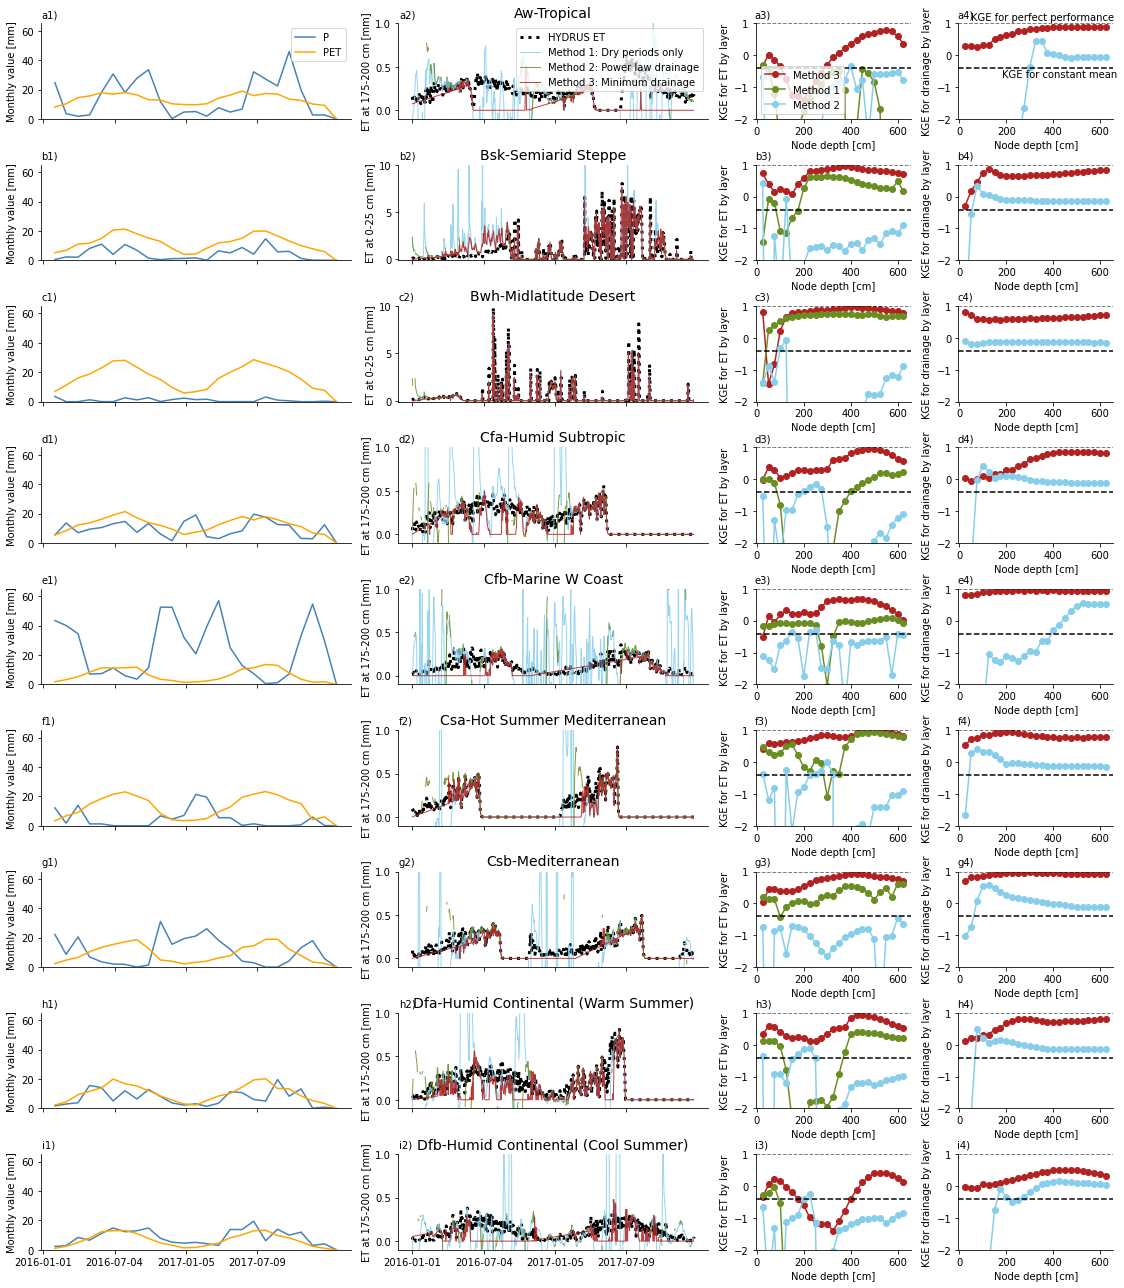

In [35]:
# plot for performance across all climates

fig, axs = plt.subplots(len(sitedf),4,figsize = (16,len(sitedf)*2),
                       gridspec_kw={'width_ratios':[2,2,1,1]})

nodespacing = 25
numports = 25

for i in range(len(sitedf)):
    key1 = sitedf.climate_type.values[i]
    performance_methods = performance_by_site[key1]
    combodata = combodatas[key1]
    DeltaStorage_list = [DeltaStoragess[key1][key] for key in DeltaStoragess[key1].keys()]
#     overall_performance_methods = overall_performance_by_site[key1]
    
    ax = axs[i,0]
    pet = pd.read_csv(loc+'petdata_'+key1+'.csv').set_index('Time')
    rain = pd.read_csv(loc+'raindata_'+key1+'.csv')
    rain['Timestamp'] = pd.to_datetime(rain.Timestamp)
    rain = rain.set_index('Timestamp')
    rain['PET'] = pet.PET.values
    dates = pd.to_datetime(rain.index).values
    ax.plot(rain.resample('M').sum().Prec, c = 'steelblue',label='P')
    ax.plot(rain.resample('M').sum().PET, c = 'orange', label='PET')
    if i==0:
        ax.legend(loc='upper right')
    ax.set_xticks(rain.index.values[::185])
    if i<len(sitedf)-1:
        ax.set_xticklabels([])
    ax.set_ylabel('Monthly value [mm]')
    ax.set_ylim(0,65)
    
    ax = axs[i,1]
    if i in [1,2]:
        node = 1
        ax.set_ylabel('ET at 0-25 cm [mm]')
        ax.set_ylim(-.1,10.)
    else:
        node = 8
        ax.set_ylabel('ET at 175-200 cm [mm]')
        ax.set_ylim(-.1,1.)
    nodeET = combodata[combodata.Nodegroup==node][['ETnode','time']].groupby('time').sum()

    ax.plot(pd.to_datetime(dates[:len(nodeET)]),
          10*nodeET,
          c='k',ls=':',zorder = -1,label='HYDRUS ET',lw=3,)
    for j in [2,1,0]:
        ax.plot(pd.to_datetime(dates[:len(DeltaStorage_list[j])]),
            10*DeltaStorage_list[j]['ET'+str(node)],
            label=titles[labellist[j]],zorder = 3-j,
            c = colors[list(colors.keys())[j]], lw=1,alpha=.85)
    
    ax.set_xticks(rain.index.values[::185])
    if i<len(sitedf)-1:
        ax.set_xticklabels([])
    if i==0:
        ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(key1,fontsize = 14)
    
    
    ax = axs[i,2]
    for method in performance_methods.keys():
        pmethod = performance_methods[method]
        pmethod = pmethod[(pmethod.Num_ports==numports)&(pmethod.Node_spacing==nodespacing)]
        ax.plot(pmethod.Node, pmethod.KGE, c = colors[method], label =' '.join(methodnames[method].split(' ')[:2]),
               marker = 'o')
    ax.axhline(-.41,c='k',ls='--')
    ax.axhline(1,c='k',ls='--',alpha=.5,lw=1)
    ax.set_ylabel('KGE for ET by layer')
    ax.set_ylim(-2,1)
    ax.set_xlabel('Node depth [cm]')
    if i==0:
        ax.legend(loc='lower left')
    
    ax = axs[i,3]
    for method in performance_methods.keys():
        pmethod = performance_methods[method]
        pmethod = pmethod[(pmethod.Num_ports==numports)&(pmethod.Node_spacing==nodespacing)]
        ax.plot(pmethod.Node, pmethod.KGE_flux, c = colors[method], label = methodnames[method],
               marker = 'o')
    ax.axhline(-.41,c='k',ls='--')
    ax.axhline(1,c='k',ls='--',alpha=.5,lw=1)
    ax.set_ylabel('KGE for drainage by layer')
    ax.set_ylim(-2,1)
    if i==0:
        ax.text(180,-.7,'KGE for constant mean')
        ax.text(50,1.1,'KGE for perfect performance')
    ax.set_xlabel('Node depth [cm]')
    
    
for ax in axs.flatten():
    ax.spines[['top','right']].set_visible(False)
    
fig.tight_layout()

labels = ['a','b','c','d','e','f','g','h','i']
for i,ax in enumerate(axs.flatten()):
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    if (int(i-int(i/4)*4))>1:
        xdist = -.07
    else:
        xdist = -.03
    ax.text(xdist,1.2, labels[int(i/4)]+str(int(i-int(i/4)*4)+1)+')', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', )

plt.savefig('HYDRUS_climates_summary.png',format='png',dpi=10,bbox_inches='tight')

In [ ]:
sitedf

In [ ]:
import matplotlib as mpl
cmap = mpl.colormaps['Set1']
# Take colors at regular intervals spanning the colormap.
colorss = cmap(np.linspace(0, 1, 9))

# Aw, Bsk, Bwh, Cfa, Cfb, Csa, Csb, Dfa, Dfb
sitedf['colors'] = [colorss[i] for i in range(9)]

for i in range(len(colorss)):
    plt.scatter([i],[i],c=colorss[i],s=100)

In [ ]:
# fig,axs = plt.subplots(1,figsize = (6,6),sharey=True)

# layerKGEMean = []
# layerKGEMin = []
# totalKGE = []
# fluxKGEMean = []
# fluxKGEMin = []

sitedf['Asynch*Aridity'] = sitedf.Aridity*sitedf.Asynch
param = 'Asynch*Aridity'

# for i in range(len(sitedf)):
#     key1 = sitedf.climate_type.values[i]
#     performance_methods = performance_by_site[key1]
#     combodata = combodatas[key1]
#     DeltaStorage_list = [DeltaStoragess[key1][key] for key in DeltaStoragess[key1].keys()]
#     overall_performance_methods = overall_performance_by_site[key1]
    
# #     ax = axs[0]
# #     for method in overall_performance_methods.keys():
# #         pmethod = overall_performance_methods[method]
# #         pmethod = pmethod[(pmethod.num_ports==numports)&(pmethod.Node_spacing==nodespacing)]
# #         ax.scatter([sitedf.iloc[i][param]],[pmethod.ET_totalKGE.min()],
# #                   c = colors[method])
# #         if method=='Mymethod':
# #             totalKGE.append(pmethod.ET_totalKGE.mean())
    
# #     ax.set_title('KGE for total ET')
# #     ax.set_yscale('symlog',linthresh=2)
# #     ax.set_yticks([-10,-1,0,1])
# #     ax.set_yticklabels(['-10','-1','0','1'])
# #     ax.set_ylim(-10,1.1)
# #     ax.set_ylabel('KGE')
    
#     ax = axs#[1]
#     for method in ['Mymethod']:#performance_methods.keys():
#         pmethod = performance_methods[method]
#         pmethod = pmethod[(pmethod.Num_ports==numports)&(pmethod.Node_spacing==nodespacing)]
#         ax.scatter([sitedf.iloc[i][param]],[pmethod.KGE.mean()],
#                   facecolors = sitedf.colors.values[i],s=100,edgecolor = 'k')
# #         if method=='Myme=].append(pmethod.KGE.mean())
    
#     ax.set_title('Mean KGE for layer ET')
# #     ax.set_yticklabels([])
    
# #     ax = axs[2]
# #     for method in performance_methods.keys():
# #         pmethod = performance_methods[method]
# #         pmethod = pmethod[(pmethod.Num_ports==numports)&(pmethod.Node_spacing==nodespacing)]
# #         ax.scatter([sitedf.iloc[i][param]],[pmethod.KGE_flux.mean()],
# #                   c = colors[method])
# #         if method=='Mymethod':
# #             fluxKGEMin.append(pmethod.KGE_flux.min())
# #             fluxKGEMean.append(pmethod.KGE_flux.mean())
   
# #     ax.set_title('Mean KGE for layer drainage')
# # #     ax.set_yticklabels([])
    
    
    
# for ax in [axs]:#axs.flatten():
#     ax.spines[['top','right']].set_visible(False)
#     ax.axhline(-.41,c='k',ls='--')
#     ax.axhline(1,c='k',ls='--',lw=1,alpha=.5)
#     ax.set_xlabel(param)

# ax.set_ylabel('KGE')
# fig.tight_layout()

# plt.savefig('climate_meanKGE.jpg',format='jpeg',dpi=100,bbox_inches='tight')

In [ ]:
import geopandas as gpd
us_outline = gpd.read_file('../../metric_extension/Data/maps_and_boundaries/US_state_outline/cb_2018_us_state_500k.shp')
state_outline = us_outline[~us_outline.STUSPS.isin(['AK','WV','PR','AS','VI','HI','GU','MP',])]

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_65360/2336509228.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  kg_class = pd.read_csv('../../LPJ-GUESS/scinet_runs/Koeppen-Geiger-ASCII.txt',delim_whitespace=True)
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_65360/2336509228.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  kg_class = gpd.sjoin(kg_class,state_outline[~(state_outline.STUSPS.isin(['AK','HI','GU','PR','VI']))])
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_65360/2336509228.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*

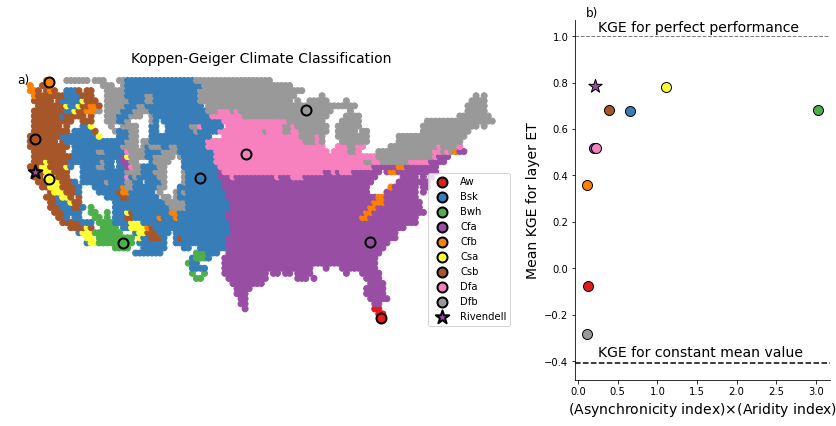

In [34]:
# http://koeppen-geiger.vu-wien.ac.at/present.htm
kg_class = pd.read_csv('../../LPJ-GUESS/scinet_runs/Koeppen-Geiger-ASCII.txt',delim_whitespace=True)
kg_class = gpd.GeoDataFrame(
    kg_class, geometry=gpd.points_from_xy(kg_class.Lon, kg_class.Lat), crs="EPSG:4326")
kg_class = gpd.sjoin(kg_class,state_outline[~(state_outline.STUSPS.isin(['AK','HI','GU','PR','VI']))])
kg_class['Cls_simple'] = [kg_class.Cls.values[i][:2] for i in range(len(kg_class))]

fig,axs = plt.subplots(1,2, figsize = (12,6),gridspec_kw = {'width_ratios':[2.,1]})

ax = axs[0]
ax.set_title('Koppen-Geiger Climate Classification',fontsize = 14)
kg_class[kg_class.Cls.isin(['Csa','Csb','Cfb','BSk','Cfa','Dfa','Dfb','Aw','BWh'])].plot(column='Cls',ax=ax,legend=True,
              cmap = 'Set1', )

for i in range(len(sitedf)):
    ax.scatter([sitedf.Longitude.values[i]], 
               [sitedf.Latitude.values[i]],
           c = sitedf.colors.values[i],
               zorder = 100,edgecolor = 'k',s = 100,lw=2,label=sitedf.climate_type.values[i].split('-')[0])
ax.axis('off')
ax.scatter([-123.64], [39.73],c=sitedf.colors[3],
           marker='*',s=200,lw=2,edgecolor = 'k', label='Rivendell',)
ax.legend()


sitedf['Asynch*Aridity'] = sitedf.Aridity*sitedf.Asynch
param = 'Asynch*Aridity'

for i in range(len(sitedf)):
    key1 = sitedf.climate_type.values[i]
    performance_methods = performance_by_site[key1]
    combodata = combodatas[key1]
    DeltaStorage_list = [DeltaStoragess[key1][key] for key in DeltaStoragess[key1].keys()]
    overall_performance_methods = overall_performance_by_site[key1]
    
    ax = axs[1]
    for method in ['Mymethod']:
        pmethod = performance_methods[method]
        pmethod = pmethod[(pmethod.Num_ports==numports)&(pmethod.Node_spacing==nodespacing)]
        ax.scatter([sitedf.iloc[i][param]],[pmethod.KGE.mean()],
                  facecolors = sitedf.colors.values[i],s=100,edgecolor = 'k')
    
    ax.set_ylabel('Mean KGE for layer ET',fontsize = 14)
ax.scatter([.51*.42],[.786],marker='*',s=200, c=sitedf.colors[3],edgecolor = 'k')
ax.set_xlabel('(Asynchronicity index)'+r'$\times$'+'(Aridity index)',
             fontsize = 14)
   
ax.text(.25,-.38,'KGE for constant mean value',fontsize = 14)
ax.text(.25, 1.02, 'KGE for perfect performance', fontsize = 14)
ax.spines[['top','right']].set_visible(False)
ax.axhline(-.41,c='k',ls='--')
ax.axhline(1,c='k',ls='--',lw=1,alpha=.5)

labels = ['a)','b)',]
for i,ax in enumerate(axs.flatten()):
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    yval = 1.
    if i==1:
        yval = 1.05
    ax.text(0,yval, labels[i], transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', )

fig.tight_layout()

plt.savefig('climate_performance.png',format='png',dpi=10,bbox_inches='tight')